In [1]:
!pip install -U evaluate
!pip install -U datasets
!pip install -U accelerate
!pip install -U transformers

In [2]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import evaluate

import csv
from collections import defaultdict

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-15 11:21:33.220006: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 11:21:33.229633: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 11:21:33.301438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 11:21:34.265365: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
OUTPUT_DIR = 'output'
VAL_RATIO = 0.3
DATA_COLUMNS = ['title', 'word_count', 'character_count', 'bigrams', 'lemma', 'pos', 'tag', 'dep', 'label', 'context_score', 'trigger_words']
LABEL_COLUMN = 'category'
DATASET_DIR = 'data/full_maven_with_category.csv'

## Load Dataset

In [4]:

def load_dataset(file_location, target_column):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_location)
    labels = sorted(list(df[target_column].unique()))
    print(len(labels))

    #convert labels in target column to numbers
    df[target_column] = df[target_column].apply(lambda x: labels.index(x))

    return df, labels

In [5]:
data_df, label_list = load_dataset(DATASET_DIR, LABEL_COLUMN)
train_data, test_data, train_labels, test_labels = train_test_split(data_df, data_df[LABEL_COLUMN], test_size=VAL_RATIO, random_state=42)

15


In [6]:
data_df.head()

,title,word_count,character_count,bigrams,lemma,pos,tag,dep,label,context_score,trigger_words,category
0,Battle of Salis,3,15,"[('Battle', 'of'), ('of', 'Salis')]","['battle', 'of', 'Salis']","['NOUN', 'ADP', 'PROPN']","['NN', 'IN', 'NNP']","['ROOT', 'prep', 'pobj']","['', '', '']","{'battle': 1.0, 'salis': 0.008540730727941325}","['battle', 'salis']",9
1,Battle of Sudoměř,3,17,"[('Battle', 'of'), ('of', 'Sudoměř')]","['battle', 'of', 'Sudoměř']","['NOUN', 'ADP', 'PROPN']","['NN', 'IN', 'NNP']","['ROOT', 'prep', 'pobj']","['WORK_OF_ART', 'WORK_OF_ART', 'WORK_OF_ART']","{'battle': 1.0, 'sudoměř': 0.008540730727941325}","['battle', 'sudoměř']",9
2,Texxas Jam,2,10,"[('Texxas', 'Jam')]","['Texxas', 'Jam']","['PROPN', 'PROPN']","['NNP', 'NNP']","['compound', 'ROOT']","['PERSON', 'PERSON']","{'texxas': 0.2043111942133731, 'jam': 1.0}","['texxas', 'jam']",0
3,Territorial era of Minnesota,4,28,"[('Territorial', 'era'), ('era', 'of'), ('of',...","['territorial', 'era', 'of', 'Minnesota']","['ADJ', 'NOUN', 'ADP', 'PROPN']","['JJ', 'NN', 'IN', 'NNP']","['amod', 'ROOT', 'prep', 'pobj']","['', '', '', 'GPE']","{'territorial': 0.4708947929883977, 'era': 0.4...","['territorial', 'era', 'minnesota']",12
4,Death of Joy Gardner,4,20,"[('Death', 'of'), ('of', 'Joy'), ('Joy', 'Gard...","['death', 'of', 'Joy', 'Gardner']","['NOUN', 'ADP', 'PROPN', 'PROPN']","['NN', 'IN', 'NNP', 'NNP']","['ROOT', 'prep', 'compound', 'pobj']","['', '', 'PERSON', 'PERSON']","{'death': 1.0, 'joy': 0.11603765993719264, 'ga...","['death', 'joy', 'gardner']",1


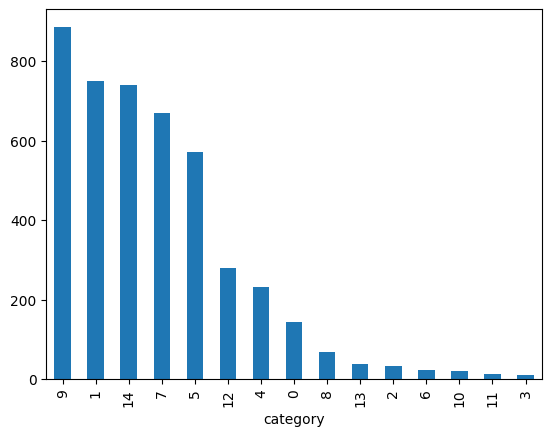

In [7]:
# @title category

from matplotlib import pyplot as plt

def plot_category_distribution(data_df):
    category_counts = data_df['category'].value_counts()
    category_counts.plot(kind='bar')
    plt.show()

plot_category_distribution(data_df)

In [8]:
print('Length of labels:', len(label_list))
print('Shape of the training data: ', train_data.shape)
print('Shape of the test data: ', test_data.shape)

Length of labels: 15
Shape of the training data:  (3131, 12)
Shape of the test data:  (1343, 12)


In [28]:
model_checkpoint = "roberta-base"
max_length = 128

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [29]:
from datasets import Dataset

def preprocess_function(input_data):
    # Extract features from input_data
    titles = input_data['title'].tolist()
    word_count = input_data['word_count'].tolist()
    character_count = input_data['character_count'].tolist()
    bigrams = input_data['bigrams'].tolist()
    lemma = input_data['lemma'].tolist()
    pos = input_data['pos'].tolist()
    tag = input_data['tag'].tolist()
    dep = input_data['dep'].tolist()
    context_score = input_data['context_score'].tolist()
    trigger_words = input_data['trigger_words'].tolist()

    # Tokenize each title separately
    tokenized_inputs = tokenizer(titles, padding=True, truncation=True, max_length=max_length)

    # Create a Dataset object
    dataset = Dataset.from_dict({
        'text': titles,
        'label': input_data[LABEL_COLUMN].tolist(),  # Assuming the label column name is LABEL_COLUMN
        'word_count': word_count,
        'character_count': character_count,
        'bigrams': bigrams,
        'lemma': lemma,
        'pos': pos,
        'tag': tag,
        'dep': dep,
        'context_score': context_score,
        'trigger_words': trigger_words,
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask']
    })

    return dataset

In [30]:
encoded_train = preprocess_function(train_data)
encoded_test = preprocess_function(test_data)
encoded_train

Dataset({
    features: ['text', 'label', 'word_count', 'character_count', 'bigrams', 'lemma', 'pos', 'tag', 'dep', 'context_score', 'trigger_words', 'input_ids', 'attention_mask'],
    num_rows: 3131
})

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(label_list), hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)
model.resize_token_embeddings(len(tokenizer)) # need to resize due to new tokens added

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(50265, 768, padding_idx=1)

In [32]:
metric_name = 'f1'
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"./snapshots/{model_name}-finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 3,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
)

In [33]:
metric = evaluate.load(metric_name)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="micro")

In [34]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_train,
    eval_dataset=encoded_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/opt/conda/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [35]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.701542,0.825019
2,No log,0.590367,0.850335
3,0.755100,0.567714,0.863738
4,0.755100,0.642049,0.865227
5,0.755100,0.640643,0.879375
6,0.281000,0.669561,0.884587
7,0.281000,0.725893,0.876396
8,0.105200,0.734415,0.889799
9,0.105200,0.724164,0.895011
10,0.105200,0.738685,0.890544


TrainOutput(global_step=3920, training_loss=0.15907382089264538, metrics={'train_runtime': 598.4421, 'train_samples_per_second': 104.638, 'train_steps_per_second': 6.55, 'total_flos': 643669429528800.0, 'train_loss': 0.15907382089264538, 'epoch': 20.0})

In [36]:
trainer.evaluate()

{'eval_loss': 0.7241635918617249,
 'eval_f1': 0.8950111690245719,
 'eval_runtime': 1.328,
 'eval_samples_per_second': 1011.266,
 'eval_steps_per_second': 63.251,
 'epoch': 20.0}

In [37]:
bert_eval = trainer.evaluate(encoded_test)
bert_eval

{'eval_loss': 0.7241635918617249,
 'eval_f1': 0.8950111690245719,
 'eval_runtime': 1.4837,
 'eval_samples_per_second': 905.188,
 'eval_steps_per_second': 56.616,
 'epoch': 20.0}

In [41]:
predictions = trainer.predict(encoded_test)

In [39]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score

predicted_labels = predictions.predictions.argmax(axis=1)
ground_truth_labels = encoded_test["label"]

accuracy = accuracy_score(ground_truth_labels, predicted_labels)

In [40]:
print(accuracy)

0.8950111690245719
